In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/weights
/kaggle/input/knee-osteoarthritis-dataset-with-severity
/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test
/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test/2
/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test/0
/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test/3
/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test/1
/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test/4
/kaggle/input/knee-osteoarthritis-dataset-with-severity/val
/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/2
/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/0
/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/3
/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/1
/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/4
/kaggle/input/knee-osteoarthritis-dataset-with-severity/test
/kaggle/input/knee-osteoarthritis-dataset-with-severity/test/2
/kaggle/

#### Here I am using the saved weights from Xception model(as it was having best accuracy among 3 models I tried) to predict the grades on test images and then using GRAD-CAM technique to visualize the output predicted by the model

In [2]:
# imports
import tensorflow as tf
import os
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

#### Some utility functions to get the work done.

In [3]:
def get_classes(data_path, classes, data):
    knee_severity={}
    count=0
    for i in range(len(classes)):
        imgs=os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i]=imgs
        count+=len(imgs)
    return knee_severity


def compute_confusion_matrix(predictions,valid_generator,class_names,model_name):
    cm=confusion_matrix(y_true=valid_generator.labels,y_pred=np.argmax(predictions, axis=1),)
    cmn=cm.astype("float")/cm.sum(axis=1)[:,np.newaxis]
    plt.subplots(figsize=(6,5))
    sns.heatmap(
        cmn,annot=True,fmt=".2f",xticklabels=class_names,yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def get_metrics(y_test,y_pred,model_name):
    acc=accuracy_score(y_test, y_pred)
    print(f"Accuracy Score -{model_name}:{acc:.2f}")
    print("\n")
    print(classification_report(y_test, y_pred))


def make_gradcam_heatmap(grad_model,img_array,pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output,preds=grad_model(img_array)
        if pred_index is None:
            pred_index=tf.argmax(preds[0])
        class_channel=preds[:,pred_index]

    grads=tape.gradient(class_channel,last_conv_layer_output)
    pooled_grads=tf.reduce_mean(grads,axis=(0,1,2))
    last_conv_layer_output=last_conv_layer_output[0]
    heatmap=last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap=tf.squeeze(heatmap)
    heatmap=tf.maximum(heatmap,0)/tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img,heatmap,alpha=0.4):
    heatmap=np.uint8(255*heatmap)
    jet = cm.get_cmap("jet")
    jet_colors=jet(np.arange(256))[:, :3]
    jet_heatmap=jet_colors[heatmap]
    jet_heatmap=tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap=jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap=tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img=jet_heatmap*alpha+img
    superimposed_img=tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img


#### Load the data 

In [4]:
base_dir='/kaggle/input/knee-osteoarthritis-dataset-with-severity/'
test_path=os.path.join(base_dir,'test')
class_names = ['Healthy','Doubtful','Minimal','Moderate','Severe']
tests_data = get_classes(test_path, class_names,'test')

#### Image data generators

In [5]:
model_name="Xception"
batch_size=256
target_size=(224,224)
aug_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,horizontal_flip=True,
brightness_range=[0.3, 0.8],width_shift_range=[-50, 0, 50, 30, -30],zoom_range=0.1,fill_mode="nearest")
noaug_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)


#### Test data genrator (use no augmentation)

In [6]:
test_generator = noaug_datagen.flow_from_directory(
    test_path,batch_size=batch_size,class_mode="categorical",target_size=target_size,shuffle=False)

Found 1656 images belonging to 5 classes.


In [7]:
y_test = test_generator.labels

#### Load the model

In [8]:
# load model
xception=tf.keras.models.load_model('/kaggle/input/weights/XCEPTION_finetuned (1).hdf5')

#### Make predictions on test data

In [9]:
predictions_xception=xception.predict(test_generator)
score_xception=xception.evaluate(test_generator,verbose=1)
print('Test loss:',score_xception[0])
print('Test acc:',score_xception[1])

7/7 [==============================] - 201s 28s/step - loss: 2.2637 - accuracy: 0.1310
Test loss: 2.2637057304382324
Test acc: 0.13103865087032318


#### Compute the metrics

In [10]:
get_metrics(
    test_generator.labels,y_pred=np.argmax(predictions_xception, axis=1),model_name=model_name)

Accuracy Score -Xception:0.13


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       639
           1       0.00      0.00      0.00       296
           2       0.00      0.00      0.00       447
           3       0.13      0.97      0.24       223
           4       0.02      0.02      0.02        51

    accuracy                           0.13      1656
   macro avg       0.03      0.20      0.05      1656
weighted avg       0.02      0.13      0.03      1656



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


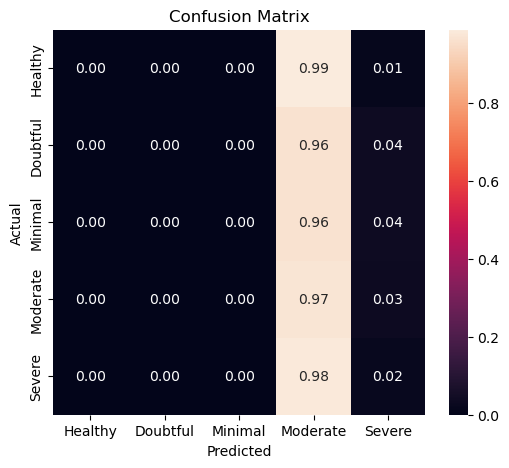

In [11]:
compute_confusion_matrix(
    predictions_xception,test_generator,class_names,f"{model_name} fine tuning",)

#### Using Grad-Cam to visualize the results

In [12]:
xception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


#### Making the GRAD-CAM model to be used for creating the heatmap for showing the areas in the image which led to the particular prediction

In [13]:
# Last layer
conv_output = xception.get_layer("global_average_pooling2d").input
# Making the model for further making GRAD-CAM
grad_model = tf.keras.models.Model(
    [xception.inputs], [conv_output, xception.output]
)
# model
xception.layers[-1].activation = None

#### Predicting the output on some images and showing their actual and true labels along with the GRAD-CAM heatmap.

Test data - Healthy


/tmp/ipykernel_20/1670669020.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


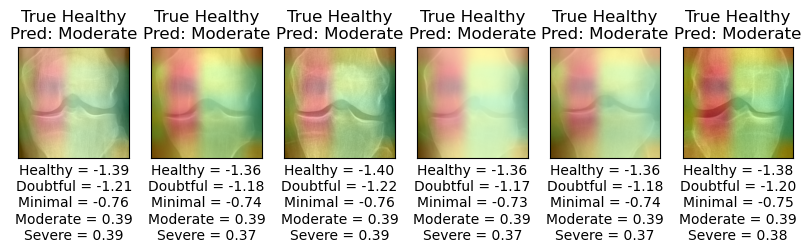

Test data - Doubtful


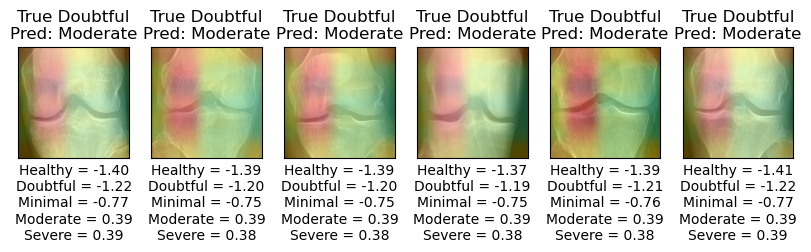

Test data - Minimal


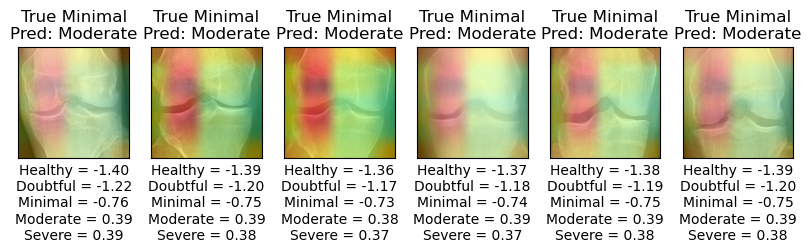

Test data - Moderate


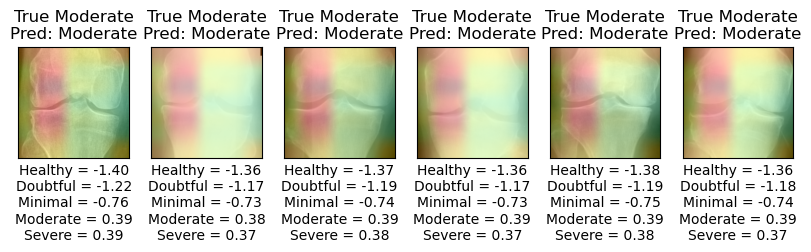

Test data - Severe


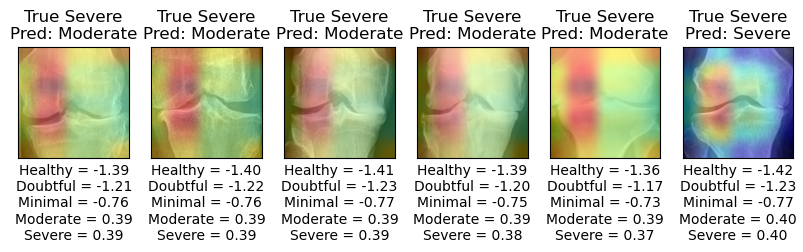

In [14]:
for k, v in tests_data.items():
    print(f"Test data - {class_names[k]}")
    plt.figure(figsize=(10,28))
    for i in range(6):
        img_path = os.path.join(test_path,str(k),v[i])
        # prepare image
        img=tf.keras.preprocessing.image.load_img(img_path,target_size=target_size)
        img=tf.keras.preprocessing.image.img_to_array(img)

        img_aux=img.copy()
        img_array=np.expand_dims(img_aux,axis=0)
        img_array=np.float32(img_array)
        img_array=tf.keras.applications.xception.preprocess_input(img_array)
        y_pred=xception.predict(img_array,verbose=0)[0]
        heatmap=make_gradcam_heatmap(grad_model,img_array)
        image=save_and_display_gradcam(img,heatmap)

        plt.subplot(1,6,1+i,xticks=[],yticks=[])
        plt.imshow(image)
        plt.title(
            f"True {class_names[k]}\nPred: {class_names[np.argmax(y_pred)]}")
        plt.xlabel(
            "\n".join([f"{c} = {p:.2f}" for c, p in zip(class_names, y_pred)]))
    plt.show() 

#### Will wrap up all these things into a streamlit webapp for better inference